In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Definition of a Curve
class Curve:
    # Constructor
    def __init__(self, list_of_points, closed=False):
        self.list_of_points = list_of_points
        self.closed = closed
        self.J = len(list_of_points)
    
    # Square Bracket Overload
    def __getitem__(self, key):
        return self.list_of_points[key % self.J]
    def __setitem__(self, key, value):
        self.list_of_points[key] = value
    
    # Length
    def __len__(self):
        return self.J
    
    # Curve Addition
    def __add__(self, otherCurve):
        if len(self) == len(otherCurve) and self.closed == otherCurve.closed:
            return Curve([self[i] + otherCurve[i] for i in range(len(self))])

    # Curve Subtraction
    def __sub__(self, otherCurve):
        if len(self) == len(otherCurve) and self.closed == otherCurve.closed:
            return Curve([self[i] - otherCurve[i] for i in range(len(self))])

    # Scalar Multiplication
    def __mul__(self, val):
        return Curve([self[i] * val for i in range(len(self))])
    
    # Curve Length
    def curveLength(self):
        l = 0
        for i in range(self.J - 1):
            edgeLength = np.linalg.norm(self[i + 1] - self[i])
            l += edgeLength ** 2
        if self.closed:
            edgeLength = np.linalg.norm(self[-1] - self[0])
            l += edgeLength ** 2
        return l

In [3]:
# p, q, T are all array
def kernelalphabeta(p, q, T, alpha=2, beta=4):
    pmq = p - q
    numerator = np.linalg.norm(np.cross(T, pmq)) ** alpha
    denominator = np.linalg.norm(pmq) ** beta
    return numerator / denominator

def kij(curve, i, j, alpha=2, beta=4):
    TI = curve[i+1] - curve[i]
    TI = TI / np.linalg.norm(TI)
    res = kernelalphabeta(curve[i], curve[j], TI, alpha, beta)
    res += kernelalphabeta(curve[i], curve[j+1], TI, alpha, beta)
    res += kernelalphabeta(curve[i+1], curve[j], TI, alpha, beta)
    res += kernelalphabeta(curve[i+1], curve[j+1], TI, alpha, beta)
    return res / 4


# Pass a list of points.
def energy(points):
    J = len(points)

    e = 0
    for i in range(J):
        for j in range(J):
            if abs(i - j) > 1 and abs(i - j + J) > 1 and abs(i - j - J) > 1:
                xi = points[i % J]
                xipm = points[(i+1) % J]
                xj = points[j % J]
                xjpm = points[(j+1) % J]
                xI = xipm - xi
                lI = np.linalg.norm(xI)
                TI = xI / lI
                kernelAB = 0
                kernelAB += kernelalphabeta(xi, xj, TI) 
                kernelAB += kernelalphabeta(xi, xjpm, TI) 
                kernelAB += kernelalphabeta(xipm, xj, TI) 
                kernelAB += kernelalphabeta(xipm, xjpm, TI)
                kernelAB *= 0.25 * lI * np.linalg.norm(xjpm-xj)
                e += kernelAB
                print(f"{i}, {j}: kernelAB: {kernelAB}")

    return e


In [4]:
# Generates the index pairs that are responsible for the derivative.
# Note that 4(J-1) pairs are generated.
def derivative_index(k, J):
    index_list = []
    for i in range(J):
        if abs(k - i) > 1 and abs(k - i + J) > 1 and abs(k - i - J) > 1:
            index_list.append((k, i))
    for i in range(J):
        if abs(k - 1 - i) > 1 and abs(k - 1 - i + J) > 1 and abs(k - 1 - i - J) > 1:
            index_list.append(((k-1) % J, i))
    for i in range(J):
        if abs(k - i) > 1 and abs(k - i + J) > 1 and abs(k - i - J) > 1:
            index_list.append((i, k))
    for i in range(J):
        if abs(k - 1 - i) > 1 and abs(k - 1 - i + J) > 1 and abs(k - 1 - i - J) > 1:
            index_list.append((i, (k-1) % J))
    

    return index_list

In [63]:
points = []
resolution = 8
for i in range(resolution):
    theta = 2 * np.pi / resolution * i
    points.append(np.array([2 * np.cos(theta), np.sin(theta), 0], dtype="float64"))
curve = Curve(points)


In [6]:
def kjk(curve, p, q, r, alpha=3, beta=6):
    k = p
    j = q
    xkEdge = curve[k+1] - curve[k]
    xkEdgeLen = np.linalg.norm(xkEdge)
    xkj = curve[k] - curve[j]
    xkjLen = np.linalg.norm(xkj)
    xi = xkEdgeLen**2 * xkjLen**2 - (np.dot(xkEdge, xkj))**2
    eta = xkjLen**beta * xkEdgeLen**alpha
    dxi = -2 * xkEdge * xkjLen**2 + 2 * xkEdgeLen**2 * xkj - 2 * np.dot(xkEdge, xkj) * (xkEdge - xkj)
    deta = beta * xkjLen**(beta - 2) * xkEdgeLen**alpha * xkj + alpha * xkjLen**beta * xkEdgeLen**(alpha-2)*(-xkEdge)
    return (xi, eta, dxi, deta)

def ijk(curve, p, q, r, alpha=3, beta=6):
    i = p
    j = q
    k = r
    xkEdge = curve[k+1] - curve[k]
    xkEdgeLen = np.linalg.norm(xkEdge)
    xij = curve[i] - curve[j]
    xijLen = np.linalg.norm(xij)
    xi = xkEdgeLen**2 * xijLen**2 - (np.dot(xkEdge, xij))**2
    eta = xijLen**beta * xkEdgeLen**alpha
    dxi = -2 * xijLen**2 * xkEdge + 2 * np.dot(xkEdge, xij) * xij
    deta = alpha * xijLen**beta * xkEdgeLen**(alpha-2) * (-xkEdge)
    return (xi, eta, dxi, deta)

def km1jkm1(curve, p, q, r, alpha=3, beta=6):
    k = p + 1
    j = q
    xkEdge = curve[k] - curve[k-1]
    xkEdgeLen = np.linalg.norm(xkEdge)
    xkmj = curve[k-1] - curve[j]
    xkmjLen = np.linalg.norm(xkmj)
    xi = xkEdgeLen**2 * xkmjLen**2 - (np.dot(xkEdge, xkmj))**2
    eta = xkmjLen**beta * xkEdgeLen**alpha
    dxi = 2 * xkmjLen**2 * xkEdge - 2 * np.dot(xkEdge, xkmj) * xkmj
    deta = alpha * xkmjLen**beta * xkEdgeLen**(alpha-2) * xkEdge
    return (xi, eta, dxi, deta)

def kjkm1(curve, p, q, r, alpha=3, beta=6):
    k = p
    j = q
    xkEdge = curve[k] - curve[k-1]
    xkEdgeLen = np.linalg.norm(xkEdge)
    xkj = curve[k] - curve[j]
    xkjLen = np.linalg.norm(xkj)
    xi = xkEdgeLen**2 * xkjLen**2 - (np.dot(xkEdge, xkj))**2
    eta = xkjLen**beta * xkEdgeLen**alpha
    dxi = 2 * xkjLen**2 * xkEdge + 2 * xkEdgeLen**2 * xkj - 2 * np.dot(xkEdge, xkj) * (xkEdge + xkj)
    deta = beta * xkEdgeLen**alpha * xkjLen**(beta-2) * xkj + alpha * xkjLen**beta * xkEdgeLen**(alpha-2) * xkEdge
    return (xi, eta, dxi, deta)

def ikj(curve, p, q, r, alpha=3, beta=6):
    i = p
    j = r
    k = q
    xjEdge = curve[j+1] - curve[j]
    xjEdgeLen = np.linalg.norm(xjEdge)
    xki = curve[k] - curve[i]
    xkiLen = np.linalg.norm(xki)
    xi = xjEdgeLen**2 * xkiLen**2 - (np.dot(xjEdge, xki))**2
    eta = xkiLen**beta * xjEdgeLen**alpha
    dxi = 2 * xjEdgeLen**2 * xki - 2 * np.dot(xjEdge, xki) * xjEdge
    deta = beta * xjEdgeLen**alpha * xkiLen**(beta-2) * xki
    return (xi, eta, dxi, deta)

# Derivative of k_{\beta}^{\alpha}
def dkalphabeta(curve, p, q, r, k, alpha=3, beta=6):
    J = len(curve)
    p = p % J
    q = q % J
    r = r % J
    k = k % J
    # (k, j, k)
    if (p, r) == (k, k):
        xiEtaSorter = kjk
        #print("kjk")
    # (i, j, k)
    elif r == k:
        xiEtaSorter = ijk
        #print("ijk")
    elif (p, r) == ((k-1)%J, (k-1)%J):
        xiEtaSorter = km1jkm1
        #print("k-1,j,k-1")
    elif (p, r) == (k, (k-1)%J):
        xiEtaSorter = kjkm1
        #print("k, j, k-1")
    elif q == k:
        xiEtaSorter = ikj
        #print("ikj")
    else:
        #print(f"k={k}: NOT DEFINED: {p}, {q}, {r}")
        return 0.0
    xi, eta, dxi, deta = xiEtaSorter(curve, p, q, r, alpha, beta)

    res = (alpha/2 * xi**(alpha/2 - 1) * dxi * eta - xi**(alpha/2) * deta) / (eta**2)
    return res

def dkij(curve, i, j, k, alpha=3, beta=6):
    res = 0
    res += dkalphabeta(curve, i, j, i, k, alpha, beta)
    res += dkalphabeta(curve, i, j+1, i, k, alpha, beta)
    res += dkalphabeta(curve, i+1, j, i, k, alpha, beta)
    res += dkalphabeta(curve, i+1, j+1, i, k, alpha, beta)
    return res / 4

In [7]:
# Derivative of \norm{x_{i+1} - x_i} \norm{x_{j+1} - x_j}
def dProductOfLengths(curve, p, q, k):
    J = len(curve)
    i = p % J
    j = q % J
    k = k % J
    xiEdge = curve[i+1] - curve[i]
    xiEdgeLen = np.linalg.norm(xiEdge)
    xjEdge = curve[j+1] - curve[j]
    xjEdgeLen = np.linalg.norm(xjEdge)
    if i == k:
        res = xjEdgeLen * (-xiEdge) / xiEdgeLen
    elif (i+1) % J == k:
        res = xjEdgeLen * xiEdge / xiEdgeLen
    elif j == k:
        res = xiEdgeLen * (-xjEdge) / xjEdgeLen
    elif (j+1) % J == k:
        res = xiEdgeLen * xjEdge / xjEdgeLen
    else:
        res = 0
    return res


In [64]:
def dEnergy(curve, alpha, beta):
    J = len(curve)
    res = Curve([np.array([0,0,0], dtype="float64") for i in range(J)])
    k = 0

    # Generate indices that are relevant
    dIndex = derivative_index(k, J)
    for k in range(J):
        for i, j in dIndex:
            xiEdgeLen = np.linalg.norm(curve[i+1] - curve[i])
            xjEdgeLen = np.linalg.norm(curve[j+1] - curve[j])
            summand = dkij(curve, i, j, k, alpha, beta) * xiEdgeLen * xjEdgeLen
            summand += kij(curve, i, j, alpha, beta) * dProductOfLengths(curve, i, j, k)
            res[k] += summand
        
    return res
dEnergy(curve, 3, 6).list_of_points


[array([-1.13643495e+00,  3.48679419e-15,  0.00000000e+00]),
 array([ 0.80132002, -0.88902737,  0.        ]),
 array([-0.22321346, -0.24953336,  0.        ]),
 array([-0.02642193, -0.05987047,  0.        ]),
 array([0.0330657, 0.       , 0.       ]),
 array([-0.02642193,  0.05987047,  0.        ]),
 array([-0.22321346,  0.24953336,  0.        ]),
 array([0.80132002, 0.88902737, 0.        ])]

In [9]:
dIndex = derivative_index(1, 4)
k = 1
for p, q in dIndex:
    r = p
    print(dkalphabeta(curve, p, q, k, k))

[ 1.38777878e-17 -1.32582521e-01  0.00000000e+00]
[-0.06629126  0.06629126  0.        ]
[ 0.06629126 -0.06629126  0.        ]
[-0.06629126  0.06629126  0.        ]


In [10]:
for p, q in derivative_index(0,5):
    print(f"{p}, {q}")
    print(dkalphabeta(curve, p, q, p, 0))
    print(dkalphabeta(curve, p+1, q, p, 0))
    print(dkalphabeta(curve, p, q+1, p, 0))
    print(dkalphabeta(curve, p+1, q+1, p, 0))
    print("-----------------------------------------------------")

0, 2
[-1.32582521e-01  1.38777878e-17  0.00000000e+00]
[0. 0. 0.]
[-0.53033009 -0.53033009  0.        ]
[0.06629126 0.06629126 0.        ]
-----------------------------------------------------
0, 3
[-0.53033009 -0.53033009  0.        ]
[0.06629126 0.06629126 0.        ]
[nan nan nan]
[nan nan nan]
-----------------------------------------------------
4, 1
[nan nan nan]
[nan nan nan]
[-1.32582521e-01  1.38777878e-17  0.00000000e+00]
[0. 0. 0.]
-----------------------------------------------------
4, 2
[-1.32582521e-01  1.38777878e-17  0.00000000e+00]
[0. 0. 0.]
[-0.53033009 -0.53033009  0.        ]
[0.06629126 0.06629126 0.        ]
-----------------------------------------------------
2, 0
[-0.06629126  0.06629126  0.        ]
[-0.53033009 -0.53033009  0.        ]
0.0
0.0
-----------------------------------------------------
3, 0
[0. 0. 0.]
[nan nan nan]
[ 0.06629126 -0.06629126  0.        ]
[-0.53033009  0.53033009  0.        ]
-----------------------------------------------------
1, 

/tmp/ipykernel_6686/2817426322.py:97: RuntimeWarning: invalid value encountered in divide
  res = (alpha/2 * xi**(alpha/2 - 1) * dxi * eta - xi**(alpha/2) * deta) / (eta**2)
/tmp/ipykernel_6686/2817426322.py:97: RuntimeWarning: invalid value encountered in double_scalars
  res = (alpha/2 * xi**(alpha/2 - 1) * dxi * eta - xi**(alpha/2) * deta) / (eta**2)


In [11]:
def curvePlot(curve):
    J = curve.J

    xpoints = []
    ypoints = []
    zpoints = []
    for i in range(J):
        xpoints.append(curve[i][0])
        ypoints.append(curve[i][1])
        zpoints.append(curve[i][2])
    
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.plot(xpoints, ypoints, zpoints)
    ax.set_xlim((-5,5))
    ax.set_ylim((-5,5))
    ax.set_zlim((-5,5))
    plt.show()

In [ ]:
# Gradient Flow
stepsize=1.0
for t in range(100):
    curve = curve - dEnergy(curve, 2, 4) * stepsize
    curvePlot(curve)

In [12]:
derivative_index(0,4)

[(0, 2), (3, 1), (2, 0), (1, 3)]

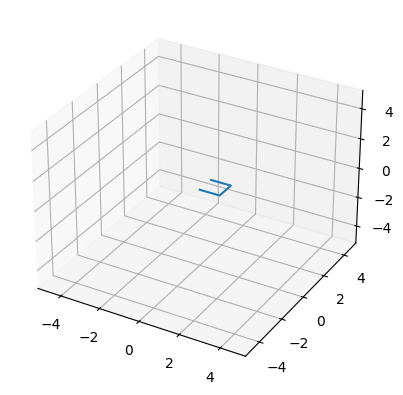

In [13]:
easy_square = Curve([
    np.array([0, 0, 0], dtype="float64"),
    np.array([1, 0, 0], dtype="float64"),
    np.array([1, 1, 0], dtype="float64"),
    np.array([0, 1, 0], dtype="float64")
    ]
)
curvePlot(easy_square)

In [50]:
# Lab
easy_square_plus = deepcopy(easy_square)
easy_square_minus = deepcopy(easy_square)
perturbation=0.00001
ALPHA=2
BETA=4
derivative_function=kjk
p = 0
q = 2
r = 0
k = 0
easy_square_plus[k] = np.array([perturbation, 0, 0])
easy_square_minus[k] = np.array([-perturbation, 0, 0])
#easy_square_plus[k] = np.array([0, perturbation, 0])
#easy_square_minus[k] = np.array([0, -perturbation, 0])
xi, eta, dxi, deta = derivative_function(easy_square, p, q, r, ALPHA, BETA)
(dxi, deta)


(array([-2.,  0.,  0.]), array([-16.,  -8.,   0.]))

In [59]:
xip, etap, dxip, detap = derivative_function(easy_square_plus, p, q, r, ALPHA, BETA)
xin, etan, dxin, detan = derivative_function(easy_square_minus, p, q, r, ALPHA, BETA)
((xip - xin) / (2*perturbation), (etap - etan) / (2*perturbation))

(-1.9999999999908977, -16.00000000274715)

In [58]:
(
    (kij(easy_square_plus, p, q, ALPHA, BETA) - kij(easy_square_minus, p, q, ALPHA, BETA)) / (2*perturbation), 
dkij(easy_square, p, q, k, alpha=ALPHA, beta=BETA)
)

(0.12500000000637002, array([0.125, 0.5  , 0.   ]))

In [48]:
# Comparison of kalphabeta values
xi, eta, dxi, deta = derivative_function(easy_square, p, q, r, ALPHA, BETA)
referenceValue = kernelalphabeta(easy_square[p], easy_square[q], (easy_square[r] - easy_square[r+1]) / (np.linalg.norm(easy_square[r] - easy_square[r+1])), alpha=ALPHA, beta=BETA)
newValue = xi**(ALPHA/2) / eta
(referenceValue, newValue)

(0.24999999999999994, 0.25000000000000006)

In [61]:
dEnergy(curve, ALPHA, BETA).list_of_points

[array([-1.66533454e-16, -4.44089210e-16,  0.00000000e+00]),
 array([-1.11022302e-16,  5.55111512e-17,  0.00000000e+00]),
 array([ 5.55111512e-17, -2.22044605e-16,  0.00000000e+00]),
 array([5.55111512e-17, 3.88578059e-16, 0.00000000e+00])]